# Machine Learning - Clustering example

###### Links: [Starbucks dataset (Kaggle)](https://www.kaggle.com/starbucks/store-locations)  |  [Article (TowardsDataScience)](https://towardsdatascience.com/clustering-geospatial-data-f0584f0b04ec)

### 0 - Setup

###### Import pckgs 

In [30]:
import warnings
warnings.filterwarnings("ignore")
from ml_utils import *

###### Import data

In [31]:
dtf = pd.read_csv('data_stores.csv')
dtf = dtf[dtf["City"]=="Las Vegas"][["City","Street Address","Longitude","Latitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id"})
dtf.head()

,id,City,Street Address,Longitude,Latitude
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11


In [32]:
# simulate data 
dtf["Potential"] = np.random.randint(low=3, high=10+1, size=len(dtf))
dtf["Staff"] = dtf["Potential"].apply(lambda x: int(np.random.rand()*x)+1)
dtf["Capacity"] = dtf["Potential"] - dtf["Staff"]
dtf["Cost"] = np.random.choice(["high","medium","low"], size=len(dtf), p=[0.4,0.5,0.1])
dtf.head()

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12,4,1,3,high
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04,10,7,3,high
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13,10,8,2,medium
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22,7,4,3,medium
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11,9,6,3,high


Shape: (156, 9)
-----------------
id --> Type:num | Nas: 0(0%) | Min-Max: (0)-(155) | Possible PK
City --> Type:cat | Nas: 0(0%) | Categories: 1
Street Address --> Type:cat | Nas: 0(0%) | Categories: 140
Longitude --> Type:num | Nas: 0(0%) | Min-Max: (-115)-(-115)
Latitude --> Type:num | Nas: 0(0%) | Min-Max: (36)-(36)
Potential --> Type:num | Nas: 0(0%) | Min-Max: (3)-(10)
Staff --> Type:num | Nas: 0(0%) | Min-Max: (1)-(10)
Capacity --> Type:num | Nas: 0(0%) | Min-Max: (0)-(9)
Cost --> Type:cat | Nas: 0(0%) | Categories: 3


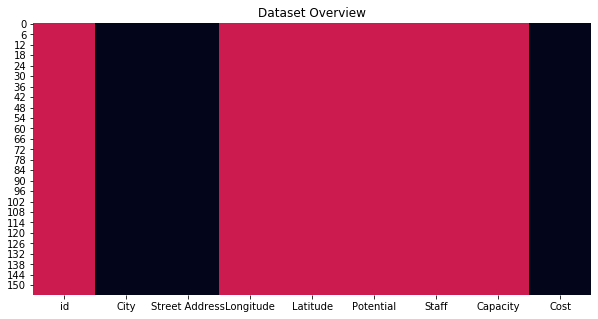

 Categerocial   Numerical   NaN 


In [33]:
dtf_overview(dtf, max_cat=3, figsize=(10,5))

### 1 - Data Analysis

###### Group variables by type
- business: Capacity, Staff, Cost
- geospatial: Street Address, Latitude, Longitude

###### Business Analysis

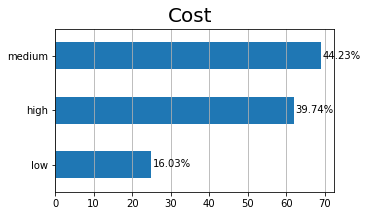

In [63]:
freqdist_plot(dtf, "Cost", figsize=(5,3))

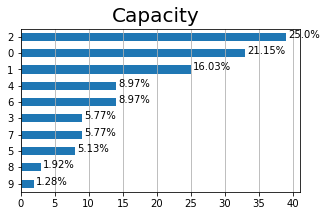

In [64]:
freqdist_plot(dtf, "Capacity", figsize=(5,3))

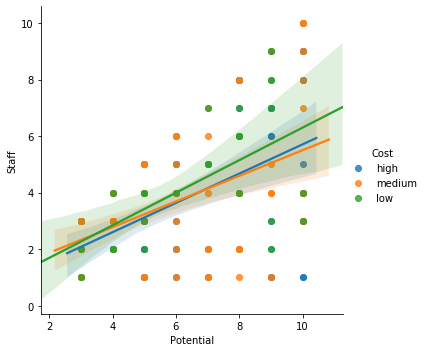

In [26]:
cross_distributions(dtf, x1="Potential", x2="Staff", y="Cost", max_cat=3, figsize=(5,5))

In [12]:
#-> Store Rationalization:
#   Find high-cost stores (orange) with low-staff (bottom) 
#   and move the staff into the low-cost stores (blue) with high-capacity (right).

###### Geospatial Analysis

In [5]:
# Get coordinates to start the map
location = get_geocoder(address="Las Vegas")
print("[lat, long]:", location)

Las Vegas, Clark County, Nevada, United States of America
[lat, long]: [36.1672559, -115.1485163]


In [72]:
map_ = plot_map(dtf, x="Latitude", y="Longitude", start=location, zoom=11, 
                tiles="cartodbpositron", popup="Street Address", 
                size="Staff", color="Cost", lst_colors=["red","green","orange"], legend=True,
                marker=None)
map_

###### Summary

In [16]:
#->1. Cluster geospatial data.
#  2. Inside each cluster, find the hubs (low cost/high capacity) and the targets (high cost/low staff).
#  3. Rationalization: iterate to move staff and close empty stores.
#  4. KPI: number of high cost stores closed.

### 2 - Baseline (k-Means / Affinity Propagation)

###### Plan:
- Clustering
- Rationalization
- Evaluate

###### Clustering

In [32]:
dtf[["Latitude","Longitude"]].head()

,Latitude,Longitude
0,36.12,-115.20
1,36.04,-115.15
2,36.13,-115.17
3,36.22,-115.28
4,36.11,-115.18


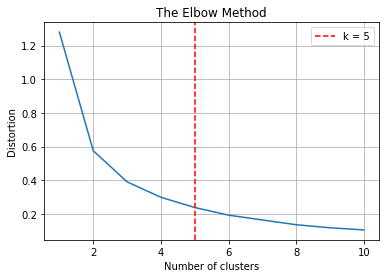

In [33]:
# K-means (euclidean geom, even clusters, must specify k)
k = find_best_k(dtf[["Latitude","Longitude"]], max_k=10, plot=True)

In [34]:
model = cluster.KMeans(n_clusters=k, init='k-means++')

--- found 5 clusters ---
cluster
4    73
1    29
2    22
3    19
0    13
Name: cluster, dtype: int64


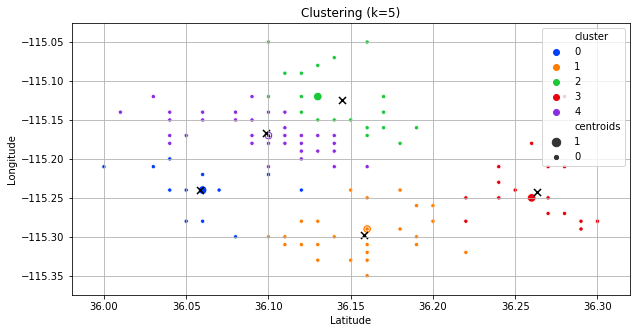

In [35]:
model, dtf_X = fit_ml_cluster(X=dtf[["Latitude","Longitude"]], model=model, figsize=(10,5))

In [34]:
# Affinity Propagation (geospatial data, uneven clusters, automatically finds k)
model = cluster.AffinityPropagation()

--- found 12 clusters ---
cluster
3     43
8     16
5     15
7     12
9     11
0     11
10    10
6      9
11     8
2      8
1      8
4      5
Name: cluster, dtype: int64


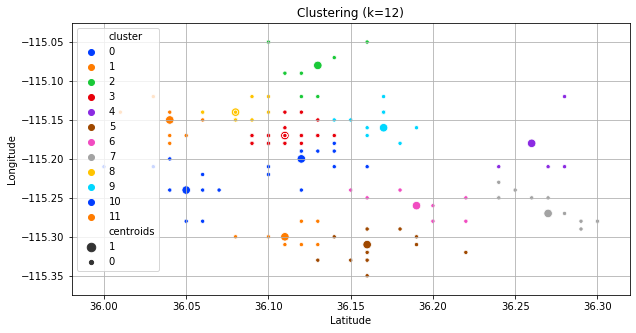

In [35]:
model, dtf_X = fit_ml_cluster(X=dtf[["Latitude","Longitude"]], model=model, figsize=(10,5))

In [36]:
# Add cluster info into original dtf
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
dtf.sample(5)

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,cluster,centroids
113,113,Las Vegas,"8780 West Charleston Blvd., 105",-115.29,36.16,6,1,5,medium,5,0
44,44,Las Vegas,7405 S Durango Dr,-115.28,36.05,3,1,2,medium,10,0
55,55,Las Vegas,"651 N. Rainbow Blvd., #110",-115.24,36.18,3,1,2,medium,6,0
131,131,Las Vegas,5757 Paradise Road,-115.14,36.08,7,5,2,medium,8,0
38,38,Las Vegas,"751 N. Rancho Drive, #110",-115.18,36.18,7,5,2,high,9,0


In [18]:
# Visualize Clusters on the map
map_ = plot_map(dtf, x="Latitude", y="Longitude", start=location, zoom=11, 
                tiles="cartodbpositron", popup="Street Address", 
                size="Staff", color="cluster", legend=True,
                marker="centroids")
map_

###### Rationalization

In [37]:
def store_rationalization(dtf):
    dtf_new = pd.DataFrame()
    for c in sorted(dtf["cluster"].unique()):
        print("--- cluster:", c, "---")
        dtf_cluster = dtf[dtf["cluster"]==c]

        ## hubs and targets
        lst_hubs = dtf_cluster[dtf_cluster["Cost"]=="low"].sort_values("Capacity").to_dict("records")
        lst_targets = dtf_cluster[dtf_cluster["Cost"]=="high"].sort_values("Staff").to_dict("records")

        ## move targets
        for target in lst_targets:
            for hub in lst_hubs:
                ### if hub has space
                if hub["Capacity"] > 0:
                    residuals = hub["Capacity"] - target["Staff"]

                    #### case of hub has still capacity: break the hub loop and do next target
                    if residuals >= 0:
                        hub["Staff"] += target["Staff"]
                        hub["Capacity"] = hub["Potential"] - hub["Staff"]
                        target["Capacity"] = target["Potential"]
                        target["Staff"] = 0
                        break

                    #### case of hub is full: continue the hub loop and do next hub
                    else:
                        hub["Capacity"] = 0
                        hub["Staff"] = hub["Potential"]
                        target["Staff"] = -residuals
                        target["Capacity"] = target["Potential"] - target["Staff"]

        dtf_new = dtf_new.append(pd.DataFrame(lst_hubs)).append(pd.DataFrame(lst_targets))  
    return dtf_new.append(dtf[dtf["Cost"]=="medium"]).reset_index(drop=True).sort_values(["cluster","Staff"])

In [38]:
dtf_new = store_rationalization(dtf)

--- cluster: 0 ---
--- cluster: 1 ---
--- cluster: 2 ---
--- cluster: 3 ---
--- cluster: 4 ---
--- cluster: 5 ---
--- cluster: 6 ---
--- cluster: 7 ---
--- cluster: 8 ---
--- cluster: 9 ---
--- cluster: 10 ---
--- cluster: 11 ---


In [39]:
dtf_new.head()

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,cluster,centroids
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12,4,1,3,high,0,1
1,98,Las Vegas,3700 W Flamingo Rd,-115.19,36.12,4,1,3,high,0,0
92,34,Las Vegas,2411 West Sahara Ave,-115.18,36.14,8,2,6,medium,0,0
128,108,Las Vegas,"4010 South Rainbow Blvd., #A",-115.24,36.12,4,2,2,medium,0,0
2,43,Las Vegas,2530 S Decatur Blvd,-115.21,36.14,5,3,2,high,0,0


###### Evaluate

In [41]:
# KPI
dtf_new["closed"] = dtf_new["Staff"].apply(lambda x: 1 if x==0 else 0)
print("closed:", dtf_new["closed"].sum())

closed: 13


In [46]:
# Visualize Rationalization on the map
map_ = plot_map(dtf_new, x="Latitude", y="Longitude", start=location, zoom=11, 
                tiles="cartodbpositron", popup="Street Address", 
                size="Staff", color="Cost", lst_colors=["red","green","orange"], legend=True,
                marker="closed")
map_

### 3 - Model Desing & Testing (Self Organizing Maps)

###### Plan:
- Clustering
- Cost Reduction Algorithm
- Evaluate

###### Clustering

In [19]:
model = minisom.MiniSom(x=4, y=4, input_len=2, neighborhood_function="gaussian", activation_distance="euclidean")

--- map shape: (4, 4) ---
--- found 16 clusters ---
cluster
5     31
11    14
14    12
8     12
0     12
1     11
7      9
3      9
9      8
4      8
13     6
6      6
15     5
10     5
2      5
12     3
Name: cluster, dtype: int64


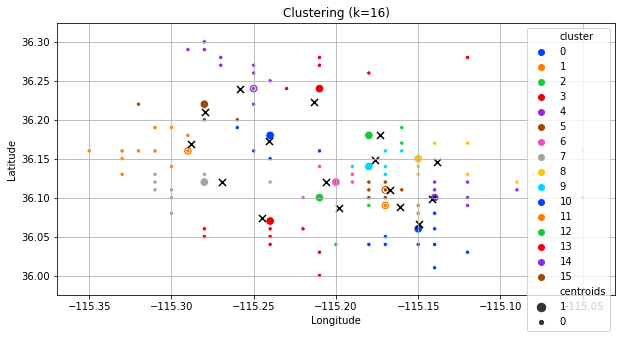

In [20]:
model, dtf_X = fit_dl_cluster(dtf[["Longitude","Latitude"]], model)

In [21]:
# Add cluster info into original dtf
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
dtf.sample(5)

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,cluster,centroids
154,154,Las Vegas,3950 Las Vegas Blvd So,-115.17,36.09,8,2,6,high,1,0
152,152,Las Vegas,4850 West Craig Road,-115.21,36.24,8,6,2,high,13,1
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12,4,1,3,high,6,1
6,6,Las Vegas,3475 Las Vegas Blvd S,-115.17,36.12,7,6,1,medium,5,0
23,23,Las Vegas,"160 E Flamingo Rd, Tenaya Village Center",-115.17,36.12,4,4,0,medium,5,0


In [22]:
# Visualize clusters on the map
map_ = plot_map(dtf, x="Latitude", y="Longitude", start=location, zoom=11, 
                tiles="cartodbpositron", popup="Street Address", 
                size="Staff", color="cluster", legend=True,
                marker="centroids")
map_

###### Cost Reduction Algorithm

In [52]:
dtf_new = store_rationalization(dtf)

--- cluster: 0 ---
--- cluster: 1 ---
--- cluster: 2 ---
--- cluster: 3 ---
--- cluster: 4 ---
--- cluster: 5 ---
--- cluster: 6 ---
--- cluster: 7 ---
--- cluster: 8 ---
--- cluster: 9 ---
--- cluster: 10 ---
--- cluster: 11 ---
--- cluster: 12 ---
--- cluster: 13 ---
--- cluster: 14 ---
--- cluster: 15 ---


In [53]:
dtf_new.head()

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,cluster,centroids
116,60,Las Vegas,4100 Blue Diamond Rd,-115.20,36.04,7,2,5,medium,0,0
0,31,Las Vegas,"10520 Southern Highlands Pkwy, #100",-115.21,36.00,5,3,2,high,0,0
1,53,Las Vegas,"3333 Blue Diamond Road, Tule Springs Village",-115.18,36.04,4,3,1,high,0,0
2,90,Las Vegas,"8975 S. Eastern Avenue, #A",-115.12,36.03,5,3,2,high,0,0
3,99,Las Vegas,"7400 S. Las Vegas Blvd., Bank of America Plaza",-115.17,36.05,3,3,0,high,0,0


###### Evaluate

In [54]:
# KPI
dtf_new["closed"] = dtf_new["Staff"].apply(lambda x: 1 if x==0 else 0)
print("closed:", dtf_new["closed"].sum())

closed: 25


In [55]:
# Visualize Rationalization on the map
map_ = plot_map(dtf_new, x="Latitude", y="Longitude", start=location, zoom=11, 
                tiles="cartodbpositron", popup="Street Address", 
                size="Staff", color="Cost", lst_colors=["red","green","orange"], legend=True,
                marker="closed")
map_